**Data**<br>
The dataset "Covertype" from the UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/Covertype or https://github.com/jeffheaton/data/blob/master/covtype.csv) contains various attributes related to the characteristics of forests, along with a target variable called Cover_Type that describes the type of forest.

In [60]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Load and Preprocess Data

In [62]:
df = pd.read_csv("Daten Blatt 3/covtype.csv")

y = df.cover_type
X = df.drop("cover_type", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.int64)
y_test = torch.tensor(y_test.values, dtype=torch.int64)

In [63]:
df.head()

,elevation,aspect,slope,horizontal_distance_to_hydrology,vertical_distance_to_hydrology,horizontal_distance_to_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,horizontal_distance_to_fire_points,...,soil_type_32,soil_type_33,soil_type_34,soil_type_35,soil_type_36,soil_type_37,soil_type_38,soil_type_39,soil_type_40,cover_type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [64]:
sorted(df["cover_type"].unique())

[1, 2, 3, 4, 5, 6, 7]

In [66]:
class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.targets[idx] - 1
        return sample, target

train_dataset = CustomDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CustomDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)


### Define Network Architecture

The Kaiming initialization adjusts the standard deviation of the normal distribution based on the chosen nonlinearity to ensure proper scaling of the weights.

Batch normalization is used normalize the activations of each mini-batch during training, which helps stabilize and accelerate the learning process by dealing with kovariant shift in hidden layers.

The Kaiming initialization adjusts the standard deviation of the normal distribution based on the chosen nonlinearity to ensure proper scaling of the weights.

This initialization method is especially good for the popular Relu activation function, which also helps to prevent overfitting.

In this case the leaky Relu activationfunction is used to preserve information from negative values of z.


In [67]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(54, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, 16)
        self.bn5 = nn.BatchNorm1d(16)
        self.fc6 = nn.Linear(16, 7)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')

    def forward(self, x):
        x = x.view(-1, 54)
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x, negative_slope=0.01)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x, negative_slope=0.01)
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.leaky_relu(x, negative_slope=0.01)
        x = self.fc4(x)
        x = self.bn4(x)
        x = F.leaky_relu(x, negative_slope=0.01)
        x = self.fc5(x)
        x = self.bn5(x)
        x = F.leaky_relu(x, negative_slope=0.01)
        x = self.fc6(x)
        return F.log_softmax(x, dim=1)

In [68]:
net = Net().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, amsgrad=True)
criterion = nn.NLLLoss()
accuracy = Accuracy(task="multiclass", num_classes=7).to(device)

train_loss_per_epoch = []
test_loss_per_epoch = []
test_accuracy_per_epoch = []

In [65]:
# Set hyperparameters
learning_rate = 0.05
n_epochs = 200
batch_size = 32

### Training Loop

In [69]:
for epoch in range(1, n_epochs + 1):
    net.train()
    with tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f"Epoch {epoch} - Training", ncols=100, position=0) as t:
        for batch_idx, (data, target) in t:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            out = net(data)
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()

    net.eval()
    train_loss_epoch = 0
    test_loss = 0
    test_accuracy_sum = 0
    with tqdm(enumerate(test_dataloader), total=len(test_dataloader), desc=f"Epoch {epoch} - Testing", ncols=100, position=0) as t:
        for batch_idx, (data, target) in t:
            data, target = data.to(device), target.to(device)
            y_pred_test = net(data)
            loss = criterion(y_pred_test, target)
            test_loss += loss.item()
            test_accuracy_sum += accuracy(y_pred_test, target)

    # Calculate training loss
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)
        y_pred_train = net(data)
        train_loss_epoch += criterion(y_pred_train, target).item()

    # Update metrics
    test_loss /= len(test_dataloader)
    test_loss_per_epoch.append(test_loss)
    train_loss_epoch /= len(train_dataloader)
    train_loss_per_epoch.append(train_loss_epoch)
    test_accuracy_avg = test_accuracy_sum / len(test_dataloader)
    test_accuracy_per_epoch.append(test_accuracy_avg.item())
    print(f"Epoch {epoch}: Train loss = {train_loss_epoch:.4f}, Test loss = {test_loss:.4f}, Test accuracy = {test_accuracy_avg * 100:.2f}%")


Epoch 92 - Testing: 100%|████████████████████████████████████████| 908/908 [00:01<00:00, 613.41it/s]


Epoch 92: Train loss = 0.1838, Test loss = 0.1971, Test accuracy = 92.19%


Epoch 93 - Testing: 100%|████████████████████████████████████████| 908/908 [00:01<00:00, 598.49it/s]


Epoch 93: Train loss = 0.1889, Test loss = 0.2033, Test accuracy = 92.05%


Epoch 94 - Testing: 100%|████████████████████████████████████████| 908/908 [00:01<00:00, 616.32it/s]


Epoch 94: Train loss = 0.1933, Test loss = 0.2089, Test accuracy = 91.58%


Epoch 95 - Testing: 100%|████████████████████████████████████████| 908/908 [00:01<00:00, 599.20it/s]


Epoch 95: Train loss = 0.1913, Test loss = 0.2049, Test accuracy = 91.90%


Epoch 96 - Testing: 100%|████████████████████████████████████████| 908/908 [00:01<00:00, 589.00it/s]


Epoch 96: Train loss = 0.1933, Test loss = 0.2076, Test accuracy = 91.50%


Epoch 97 - Testing: 100%|████████████████████████████████████████| 908/908 [00:01<00:00, 613.93it/s]


Epoch 97: Train loss = 0.1892, Test loss = 0.2032, Test accuracy = 92.15%


Epoch 98 - Testing: 100%|████████████████████████████████████████| 908/908 [00:01<00:00, 613.98it/s]


Epoch 98: Train loss = 0.1827, Test loss = 0.1977, Test accuracy = 92.13%


Epoch 99 - Testing: 100%|████████████████████████████████████████| 908/908 [00:01<00:00, 598.77it/s]


Epoch 99: Train loss = 0.1838, Test loss = 0.1989, Test accuracy = 92.12%


Epoch 100 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 586.24it/s]


Epoch 100: Train loss = 0.1851, Test loss = 0.1985, Test accuracy = 92.17%


Epoch 101 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 553.02it/s]


Epoch 101: Train loss = 0.1836, Test loss = 0.1973, Test accuracy = 92.26%


Epoch 102 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 573.63it/s]


Epoch 102: Train loss = 0.1833, Test loss = 0.1977, Test accuracy = 92.22%


Epoch 103 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 623.51it/s]


Epoch 103: Train loss = 0.1816, Test loss = 0.1955, Test accuracy = 92.36%


Epoch 104 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 617.03it/s]


Epoch 104: Train loss = 0.1796, Test loss = 0.1934, Test accuracy = 92.39%


Epoch 105 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 609.72it/s]


Epoch 105: Train loss = 0.1877, Test loss = 0.2008, Test accuracy = 92.28%


Epoch 106 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 582.00it/s]


Epoch 106: Train loss = 0.1782, Test loss = 0.1937, Test accuracy = 92.32%


Epoch 107 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 600.36it/s]


Epoch 107: Train loss = 0.1817, Test loss = 0.1955, Test accuracy = 92.28%


Epoch 108 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 580.56it/s]


Epoch 108: Train loss = 0.1811, Test loss = 0.1957, Test accuracy = 92.35%


Epoch 109 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 645.92it/s]


Epoch 109: Train loss = 0.1894, Test loss = 0.2036, Test accuracy = 91.90%


Epoch 110 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 614.34it/s]


Epoch 110: Train loss = 0.1809, Test loss = 0.1943, Test accuracy = 92.26%


Epoch 111 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 579.68it/s]


Epoch 111: Train loss = 0.1831, Test loss = 0.1977, Test accuracy = 92.13%


Epoch 112 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 564.36it/s]


Epoch 112: Train loss = 0.1853, Test loss = 0.1997, Test accuracy = 92.18%


Epoch 113 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 593.17it/s]


Epoch 113: Train loss = 0.1810, Test loss = 0.1957, Test accuracy = 92.22%


Epoch 114 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 621.11it/s]


Epoch 114: Train loss = 0.1867, Test loss = 0.2025, Test accuracy = 91.95%


Epoch 115 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 623.83it/s]


Epoch 115: Train loss = 0.1776, Test loss = 0.1930, Test accuracy = 92.38%


Epoch 116 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 612.91it/s]


Epoch 116: Train loss = 0.1841, Test loss = 0.1991, Test accuracy = 92.20%


Epoch 117 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 609.89it/s]


Epoch 117: Train loss = 0.1746, Test loss = 0.1889, Test accuracy = 92.57%


Epoch 118 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 626.93it/s]


Epoch 118: Train loss = 0.1813, Test loss = 0.1955, Test accuracy = 92.30%


Epoch 119 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 587.75it/s]


Epoch 119: Train loss = 0.1800, Test loss = 0.1945, Test accuracy = 92.31%


Epoch 120 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 625.18it/s]


Epoch 120: Train loss = 0.1778, Test loss = 0.1929, Test accuracy = 92.39%


Epoch 121 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 608.75it/s]


Epoch 121: Train loss = 0.1886, Test loss = 0.2029, Test accuracy = 91.86%


Epoch 122 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 610.19it/s]


Epoch 122: Train loss = 0.1728, Test loss = 0.1874, Test accuracy = 92.56%


Epoch 123 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 619.99it/s]


Epoch 123: Train loss = 0.1864, Test loss = 0.2011, Test accuracy = 92.10%


Epoch 124 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 578.50it/s]


Epoch 124: Train loss = 0.1822, Test loss = 0.1964, Test accuracy = 92.05%


Epoch 125 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 600.25it/s]


Epoch 125: Train loss = 0.1831, Test loss = 0.1976, Test accuracy = 92.30%


Epoch 126 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 607.21it/s]


Epoch 126: Train loss = 0.1748, Test loss = 0.1904, Test accuracy = 92.50%


Epoch 127 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 566.89it/s]


Epoch 127: Train loss = 0.1733, Test loss = 0.1874, Test accuracy = 92.70%


Epoch 128 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 606.17it/s]


Epoch 128: Train loss = 0.1808, Test loss = 0.1943, Test accuracy = 92.47%


Epoch 129 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 565.77it/s]


Epoch 129: Train loss = 0.1769, Test loss = 0.1910, Test accuracy = 92.37%


Epoch 130 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 608.34it/s]


Epoch 130: Train loss = 0.1800, Test loss = 0.1953, Test accuracy = 92.21%


Epoch 131 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 622.38it/s]


Epoch 131: Train loss = 0.1748, Test loss = 0.1891, Test accuracy = 92.60%


Epoch 132 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 593.86it/s]


Epoch 132: Train loss = 0.1738, Test loss = 0.1889, Test accuracy = 92.60%


Epoch 133 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 609.00it/s]


Epoch 133: Train loss = 0.1751, Test loss = 0.1896, Test accuracy = 92.54%


Epoch 134 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 604.70it/s]


Epoch 134: Train loss = 0.1759, Test loss = 0.1912, Test accuracy = 92.53%


Epoch 135 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 573.69it/s]


Epoch 135: Train loss = 0.1761, Test loss = 0.1913, Test accuracy = 92.53%


Epoch 136 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 617.84it/s]


Epoch 136: Train loss = 0.1796, Test loss = 0.1939, Test accuracy = 92.26%


Epoch 137 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 615.92it/s]


Epoch 137: Train loss = 0.1776, Test loss = 0.1935, Test accuracy = 92.34%


Epoch 138 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 586.07it/s]


Epoch 138: Train loss = 0.1793, Test loss = 0.1935, Test accuracy = 92.33%


Epoch 139 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 583.16it/s]


Epoch 139: Train loss = 0.1754, Test loss = 0.1906, Test accuracy = 92.56%


Epoch 140 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 588.29it/s]


Epoch 140: Train loss = 0.1734, Test loss = 0.1890, Test accuracy = 92.51%


Epoch 141 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 613.32it/s]


Epoch 141: Train loss = 0.1707, Test loss = 0.1860, Test accuracy = 92.55%


Epoch 142 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 606.51it/s]


Epoch 142: Train loss = 0.1779, Test loss = 0.1928, Test accuracy = 92.53%


Epoch 143 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 572.87it/s]


Epoch 143: Train loss = 0.1687, Test loss = 0.1835, Test accuracy = 92.76%


Epoch 144 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 642.67it/s]


Epoch 144: Train loss = 0.1720, Test loss = 0.1873, Test accuracy = 92.76%


Epoch 145 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 643.37it/s]


Epoch 145: Train loss = 0.1823, Test loss = 0.1968, Test accuracy = 92.20%


Epoch 146 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 556.96it/s]


Epoch 146: Train loss = 0.1753, Test loss = 0.1909, Test accuracy = 92.64%


Epoch 147 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 617.36it/s]


Epoch 147: Train loss = 0.1751, Test loss = 0.1899, Test accuracy = 92.55%


Epoch 148 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 635.88it/s]


Epoch 148: Train loss = 0.1843, Test loss = 0.1997, Test accuracy = 92.22%


Epoch 149 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 640.72it/s]


Epoch 149: Train loss = 0.1729, Test loss = 0.1879, Test accuracy = 92.58%


Epoch 150 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 627.49it/s]


Epoch 150: Train loss = 0.1740, Test loss = 0.1896, Test accuracy = 92.53%


Epoch 151 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 578.05it/s]


Epoch 151: Train loss = 0.1766, Test loss = 0.1920, Test accuracy = 92.46%


Epoch 152 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 540.77it/s]


Epoch 152: Train loss = 0.1747, Test loss = 0.1905, Test accuracy = 92.42%


Epoch 153 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 556.66it/s]


Epoch 153: Train loss = 0.1734, Test loss = 0.1876, Test accuracy = 92.55%


Epoch 154 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 520.06it/s]


Epoch 154: Train loss = 0.1712, Test loss = 0.1859, Test accuracy = 92.70%


Epoch 155 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 585.06it/s]


Epoch 155: Train loss = 0.1789, Test loss = 0.1941, Test accuracy = 92.48%


Epoch 156 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 580.40it/s]


Epoch 156: Train loss = 0.1752, Test loss = 0.1900, Test accuracy = 92.66%


Epoch 157 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 577.71it/s]


Epoch 157: Train loss = 0.1735, Test loss = 0.1903, Test accuracy = 92.59%


Epoch 158 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 580.21it/s]


Epoch 158: Train loss = 0.1720, Test loss = 0.1876, Test accuracy = 92.73%


Epoch 159 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 554.31it/s]


Epoch 159: Train loss = 0.1781, Test loss = 0.1934, Test accuracy = 92.34%


Epoch 160 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 578.81it/s]


Epoch 160: Train loss = 0.1737, Test loss = 0.1895, Test accuracy = 92.32%


Epoch 161 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 560.80it/s]


Epoch 161: Train loss = 0.1655, Test loss = 0.1813, Test accuracy = 92.78%


Epoch 162 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 544.91it/s]


Epoch 162: Train loss = 0.1716, Test loss = 0.1866, Test accuracy = 92.85%


Epoch 163 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 573.48it/s]


Epoch 163: Train loss = 0.1691, Test loss = 0.1845, Test accuracy = 92.89%


Epoch 164 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 571.41it/s]


Epoch 164: Train loss = 0.1757, Test loss = 0.1909, Test accuracy = 92.55%


Epoch 165 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 599.49it/s]


Epoch 165: Train loss = 0.1724, Test loss = 0.1877, Test accuracy = 92.74%


Epoch 166 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 579.25it/s]


Epoch 166: Train loss = 0.1791, Test loss = 0.1948, Test accuracy = 92.02%


Epoch 167 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 562.88it/s]


Epoch 167: Train loss = 0.1694, Test loss = 0.1848, Test accuracy = 92.72%


Epoch 168 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 585.95it/s]


Epoch 168: Train loss = 0.1703, Test loss = 0.1887, Test accuracy = 92.67%


Epoch 169 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 652.13it/s]


Epoch 169: Train loss = 0.1744, Test loss = 0.1899, Test accuracy = 92.47%


Epoch 170 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 626.89it/s]


Epoch 170: Train loss = 0.1792, Test loss = 0.1949, Test accuracy = 92.23%


Epoch 171 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 616.35it/s]


Epoch 171: Train loss = 0.1696, Test loss = 0.1855, Test accuracy = 92.74%


Epoch 172 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 607.88it/s]


Epoch 172: Train loss = 0.1760, Test loss = 0.1923, Test accuracy = 92.32%


Epoch 173 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 591.33it/s]


Epoch 173: Train loss = 0.1690, Test loss = 0.1850, Test accuracy = 92.67%


Epoch 174 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 615.36it/s]


Epoch 174: Train loss = 0.1770, Test loss = 0.1930, Test accuracy = 92.59%


Epoch 175 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 604.36it/s]


Epoch 175: Train loss = 0.1717, Test loss = 0.1873, Test accuracy = 92.55%


Epoch 176 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 584.47it/s]


Epoch 176: Train loss = 0.1686, Test loss = 0.1844, Test accuracy = 92.71%


Epoch 177 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 615.35it/s]


Epoch 177: Train loss = 0.1694, Test loss = 0.1853, Test accuracy = 92.61%


Epoch 178 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 621.54it/s]


Epoch 178: Train loss = 0.1695, Test loss = 0.1852, Test accuracy = 92.72%


Epoch 179 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 629.82it/s]


Epoch 179: Train loss = 0.1761, Test loss = 0.1923, Test accuracy = 92.40%


Epoch 180 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 579.42it/s]


Epoch 180: Train loss = 0.1749, Test loss = 0.1907, Test accuracy = 92.51%


Epoch 181 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 566.37it/s]


Epoch 181: Train loss = 0.1692, Test loss = 0.1846, Test accuracy = 92.87%


Epoch 182 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 581.42it/s]


Epoch 182: Train loss = 0.1720, Test loss = 0.1873, Test accuracy = 92.60%


Epoch 183 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 620.98it/s]


Epoch 183: Train loss = 0.1681, Test loss = 0.1825, Test accuracy = 92.80%


Epoch 184 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 608.77it/s]


Epoch 184: Train loss = 0.1732, Test loss = 0.1885, Test accuracy = 92.66%


Epoch 185 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 588.28it/s]


Epoch 185: Train loss = 0.1698, Test loss = 0.1848, Test accuracy = 92.78%


Epoch 186 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 607.66it/s]


Epoch 186: Train loss = 0.1686, Test loss = 0.1841, Test accuracy = 92.74%


Epoch 187 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 565.45it/s]


Epoch 187: Train loss = 0.1677, Test loss = 0.1836, Test accuracy = 92.66%


Epoch 188 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 592.61it/s]


Epoch 188: Train loss = 0.1684, Test loss = 0.1837, Test accuracy = 92.78%


Epoch 189 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 640.29it/s]


Epoch 189: Train loss = 0.1699, Test loss = 0.1850, Test accuracy = 92.86%


Epoch 190 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 594.55it/s]


Epoch 190: Train loss = 0.1652, Test loss = 0.1805, Test accuracy = 93.02%


Epoch 191 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 587.31it/s]


Epoch 191: Train loss = 0.1723, Test loss = 0.1881, Test accuracy = 92.63%


Epoch 192 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 558.14it/s]


Epoch 192: Train loss = 0.1729, Test loss = 0.1881, Test accuracy = 92.57%


Epoch 193 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 551.15it/s]


Epoch 193: Train loss = 0.1639, Test loss = 0.1811, Test accuracy = 92.90%


Epoch 194 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 604.52it/s]


Epoch 194: Train loss = 0.1688, Test loss = 0.1850, Test accuracy = 92.80%


Epoch 195 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 620.10it/s]


Epoch 195: Train loss = 0.1697, Test loss = 0.1856, Test accuracy = 92.71%


Epoch 196 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 627.41it/s]


Epoch 196: Train loss = 0.1663, Test loss = 0.1831, Test accuracy = 92.75%


Epoch 197 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 597.62it/s]


Epoch 197: Train loss = 0.1600, Test loss = 0.1763, Test accuracy = 92.96%


Epoch 198 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 626.67it/s]


Epoch 198: Train loss = 0.1619, Test loss = 0.1788, Test accuracy = 92.94%


Epoch 199 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 560.00it/s]


Epoch 199: Train loss = 0.1632, Test loss = 0.1788, Test accuracy = 93.05%


Epoch 200 - Testing: 100%|███████████████████████████████████████| 908/908 [00:01<00:00, 599.09it/s]


Epoch 200: Train loss = 0.1744, Test loss = 0.1896, Test accuracy = 92.72%


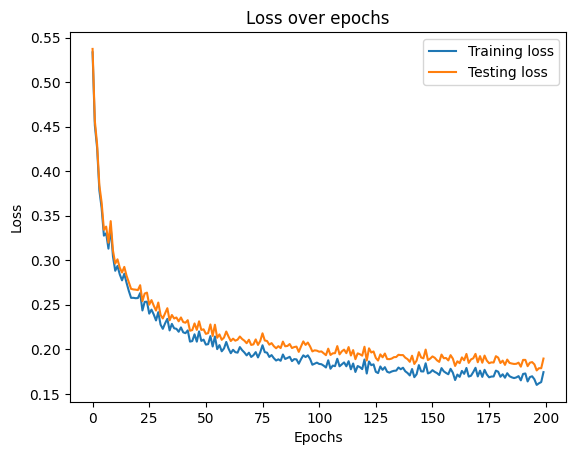

In [70]:
plt.plot(train_loss_per_epoch, label="Training loss")
plt.plot(test_loss_per_epoch, label="Testing loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over epochs")
plt.legend()
plt.show()

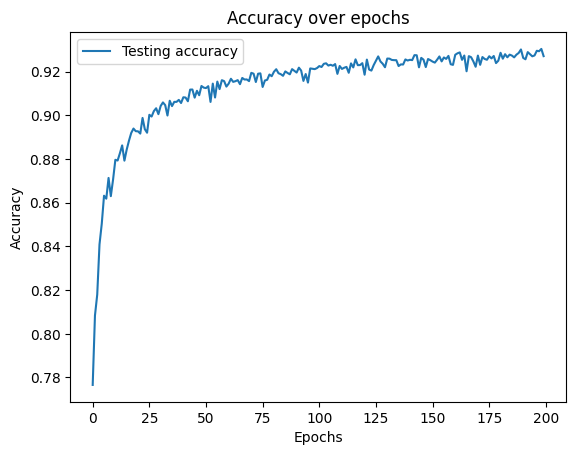

In [71]:
plt.plot(test_accuracy_per_epoch, label="Testing accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over epochs")
plt.legend()
plt.show()

In [72]:
print("Test accuracy: {:.2f}%".format(test_accuracy_per_epoch[-1] * 100))
print("Test loss: {:.4f}".format(test_loss_per_epoch[-1]))

Test accuracy: 92.72%
Test loss: 0.1896
